<a href="https://colab.research.google.com/github/freejae98/freejae98.github.io/blob/master/2022_04_11_Steel_REG_ML_6_3step(1_F)_Length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [3]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

In [4]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [101]:
#################################################################################
#
# ----- Feature 1, MLP 버전 -------
#
#################################################################################


# Data Loading
df = pd.read_excel('/content/Rev_dataset.xlsx')   #dataset_6 사용
df.set_index('Date', inplace=True)

X_colname = ['MA5']
raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = int(len(raw_all.index) * (1- PCT))

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters - 시작점을 달리할 경우 정확도에 어떤 영향을 얻을 수 있는지?

start_point = '2018-12-30'     #기존 시작점 : '2019-12-30'
criteria = '2020-12-01'     #기존 시작점 : '2021-09-01'

scaler = preprocessing.MinMaxScaler()
# sequence = 15   # → optimization 진행
batch_size = 16
epoch = 1000
verbose = 1  # 원래는 1
dropout_ratio = 0

#며칠이나 이후 것을 예상할 것인지 (20 = 4주 후)
predict_day = 5*4 # 4주 후


# Feature Engineering
## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
train = raw_all.loc[(raw_all.index >= start_point) & (raw_all.index < criteria)]

test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

print('Train_start:', train.index[0])
print('Test_start:', test.index[0])



#데이터 제대로 들어갔는지 확인
# train = np.array(train)

# aX_train, aY_train = [], []
# for index in range(0, len(train) - sequence - predict_day):
#     aX_train.append(train[index: index + sequence])
#     aY_train.append(train[index + sequence + predict_day])


# Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)



Train_size: (501, 1) Test_size: (306, 1)
Train_start: 2018-12-31 00:00:00
Test_start: 2020-12-01 00:00:00


X_train: (476, 5, 1) Y_train: (476, 1)
X_test: (281, 5, 1) Y_test: (281, 1)
Reshaping for MLP
X_train: (476, 5) Y_train: (476, 1)
X_test: (281, 5) Y_test: (281, 1)
Epoch 1/1000
30/30 [==============================] - 1s 10ms/step - loss: 0.0464 - MAE: 0.1648 - val_loss: 0.1578 - val_MAE: 0.2979
Epoch 2/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.0211 - MAE: 0.1226 - val_loss: 0.1822 - val_MAE: 0.3225
Epoch 3/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0199 - MAE: 0.1175 - val_loss: 0.3903 - val_MAE: 0.5398
Epoch 4/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.0204 - MAE: 0.1183 - val_loss: 0.2047 - val_MAE: 0.3573
Epoch 5/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0189 - MAE: 0.1131 - val_loss: 0.2322 - val_MAE: 0.3908
Epoch 6/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.0171 - MAE: 0.1078 - val_loss: 0.2937 - val_MAE: 0.4585
Epoch 7/1000
30/30 [=======================

,MAE,MSE,MAPE
Train,14.25,346.49,2.94
Test,145.40,"24,846.07",17.01


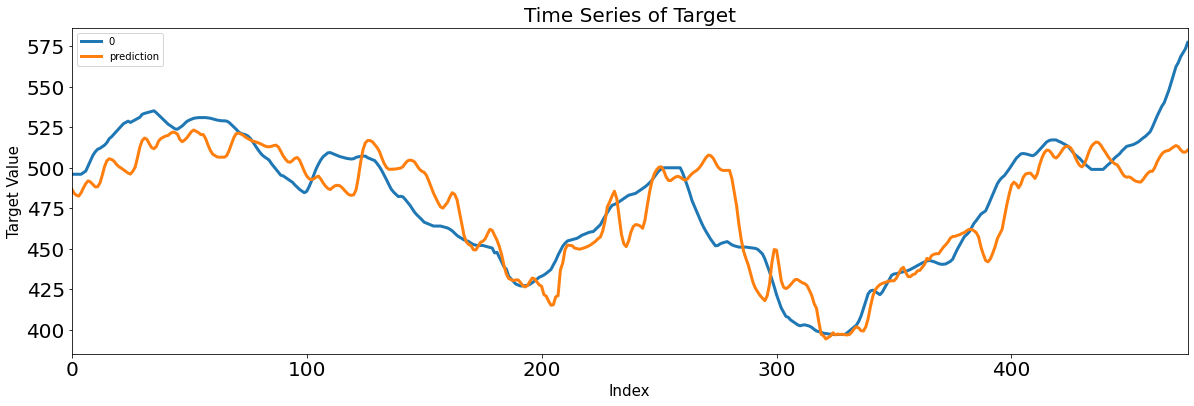

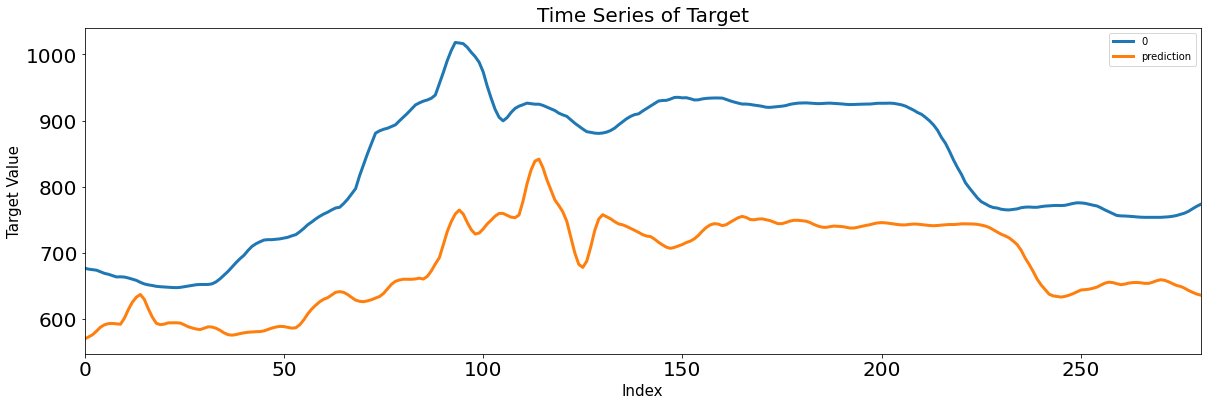

In [102]:
# sequence = 5
# epoch = 37

# simul_test = 0   # 시뮬 테스트 중이면 1 설정, 아니면 0

# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 50, mode = 'min')


# ####################### iterations #######################
# Score = dict()
# seqsize_list = [i for i in range(1, 21, 1)]
# for i in tqdm(seqsize_list):
#     sequence = i

    # X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])
    
    
## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)


model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['MAE'])
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test), callbacks = [early_stopping])

# plt.plot(pd.DataFrame(model_fit.history))
# plt.grid(True)
# plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)
if simul_test == 1:
    Score[str(sequence)] = Score_MLP


# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_test), graph_on=True)

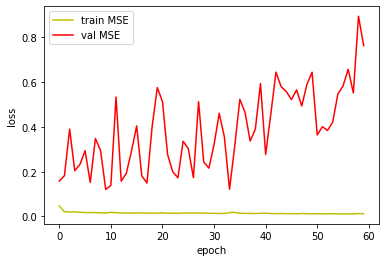

In [103]:
# 5. 모델 학습과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

loss_ax.plot(model_fit.history['loss'], 'y', label = 'train MSE')
loss_ax.plot(model_fit.history['val_loss'], 'r', label = 'val MSE')
# acc_ax.plot(model_fit.history['MAE'], 'b', label = 'train MAE')
# acc_ax.plot(model_fit.history['val_MAE'], 'g', label = 'val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'auto')
# acc_ax.legend(loc = 'lower left')

plt.show()

In [104]:
if simul_test == 1:
    # Performance plot by sequence length
    seq_test = pd.DataFrame()
    for key, val in Score.items():
        seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

    seq_test = seq_test.T
    seq_test.index = seqsize_list
    seq_test['MSE'].plot(figsize=(12,4))
    plt.show()

X_train: (476, 5, 1) Y_train: (476, 1)
X_test: (281, 5, 1) Y_test: (281, 1)
Epoch 1/1000
30/30 [==============================] - 4s 34ms/step - loss: 0.0430 - val_loss: 0.3442
Epoch 2/1000
30/30 [==============================] - 0s 16ms/step - loss: 0.0229 - val_loss: 0.3578
Epoch 3/1000
30/30 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.1635
Epoch 4/1000
30/30 [==============================] - 1s 18ms/step - loss: 0.0211 - val_loss: 0.4754
Epoch 5/1000
30/30 [==============================] - 1s 18ms/step - loss: 0.0208 - val_loss: 0.3181
Epoch 6/1000
30/30 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.4170
Epoch 7/1000
30/30 [==============================] - 0s 15ms/step - loss: 0.0221 - val_loss: 0.4174
Epoch 8/1000
30/30 [==============================] - 0s 16ms/step - loss: 0.0211 - val_loss: 0.2329
Epoch 9/1000
30/30 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 1.1438
Epoch 10/1000
3

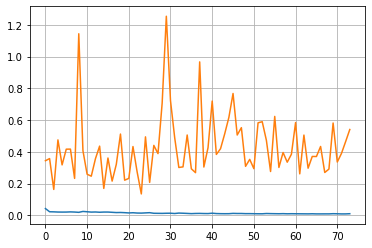

9/9 [==============================] - 0s 5ms/step - loss: 1.1745e-14


,MAE,MSE,MAPE
Train,12.90,305.35,2.66
Test,118.53,"17,599.30",13.83


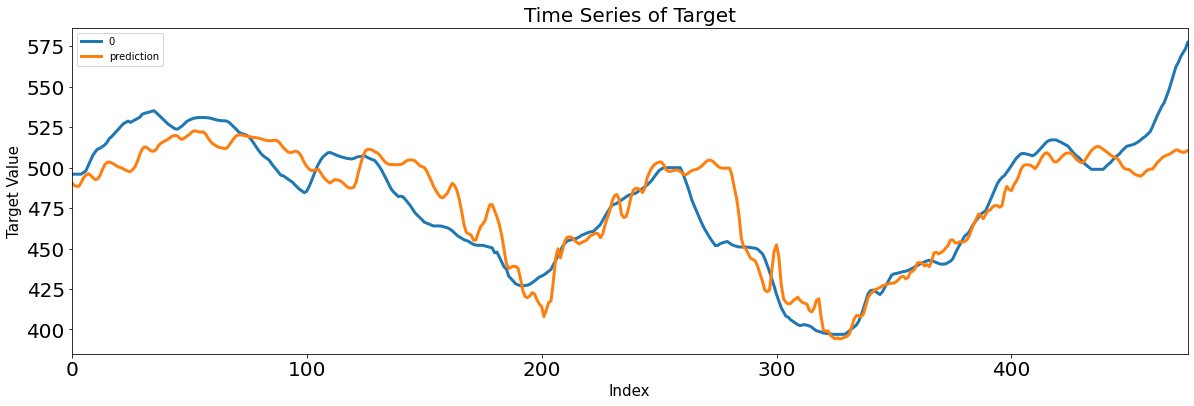

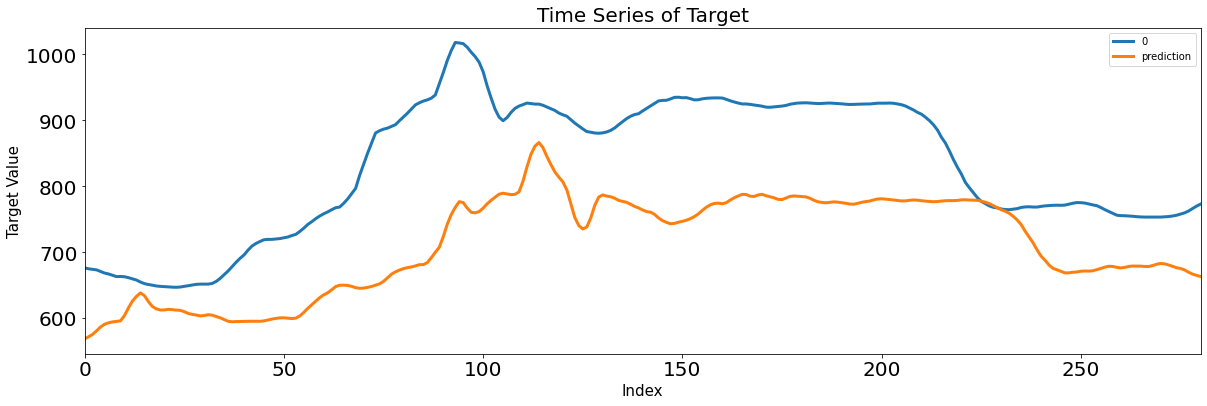

In [105]:
#################################################################################
#
# ----- Feature 1, RNN 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = round(len(raw_all.index) * (1- PCT), 0)

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# # Feature Engineering
# ## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
# test = raw_all.loc[raw_all.index >= criteria,:]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

# ## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)



####################### iterations #######################
# Score = dict()
# seqsize_list = [i for i in range(1, 21, 1)]
# for i in tqdm(seqsize_list):
#     sequence = i

    # ## X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])

# ## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test), callbacks = [early_stopping])

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)
if simul_test == 1:
    Score[str(sequence)] = Score_RNN

In [106]:
if simul_test == 1:
    # Performance plot by sequence length
    seq_test = pd.DataFrame()
    for key, val in Score.items():
        seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

    seq_test = seq_test.T
    seq_test.index = seqsize_list
    seq_test['MSE'].plot(figsize=(12,4))
    plt.show()

X_train: (476, 5, 1) Y_train: (476, 1)
X_test: (281, 5, 1) Y_test: (281, 1)
Epoch 1/1000
30/30 [==============================] - 7s 78ms/step - loss: 0.1346 - val_loss: 1.6870
Epoch 2/1000
30/30 [==============================] - 2s 50ms/step - loss: 0.0336 - val_loss: 1.9568
Epoch 3/1000
30/30 [==============================] - 1s 50ms/step - loss: 0.0233 - val_loss: 9.6041
Epoch 4/1000
30/30 [==============================] - 1s 50ms/step - loss: 0.0231 - val_loss: 6.3790
Epoch 5/1000
30/30 [==============================] - 1s 50ms/step - loss: 0.0225 - val_loss: 19.0729
Epoch 6/1000
30/30 [==============================] - 2s 52ms/step - loss: 0.0223 - val_loss: 9.6223
Epoch 7/1000
30/30 [==============================] - 1s 48ms/step - loss: 0.0221 - val_loss: 3.0404
Epoch 8/1000
30/30 [==============================] - 1s 48ms/step - loss: 0.0227 - val_loss: 7.7288
Epoch 9/1000
30/30 [==============================] - 1s 48ms/step - loss: 0.0234 - val_loss: 0.4695
Epoch 10/1000


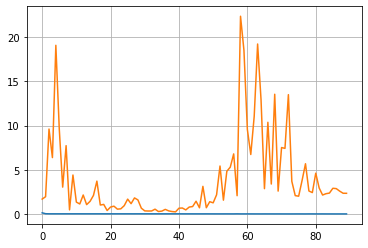

9/9 [==============================] - 0s 18ms/step - loss: 2.2884e-15


,MAE,MSE,MAPE
Train,14.85,344.82,3.09
Test,259.30,"76,221.26",30.21


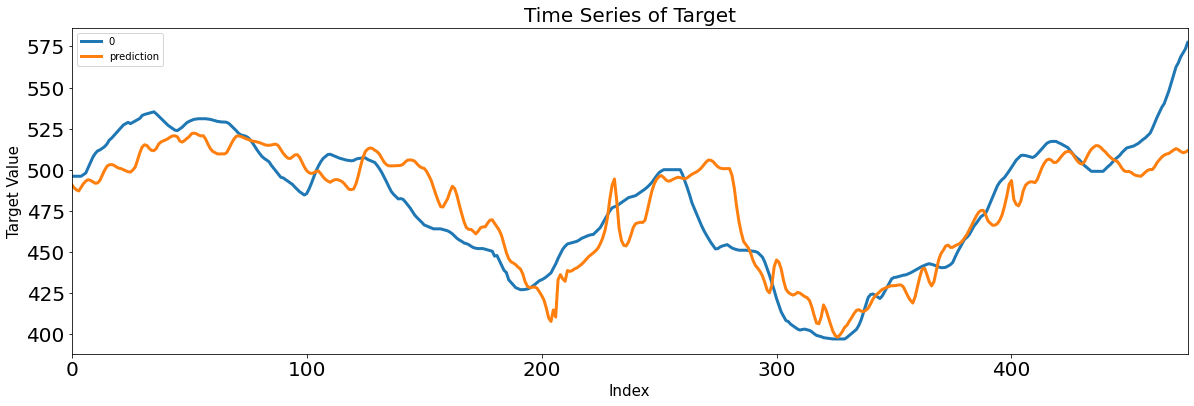

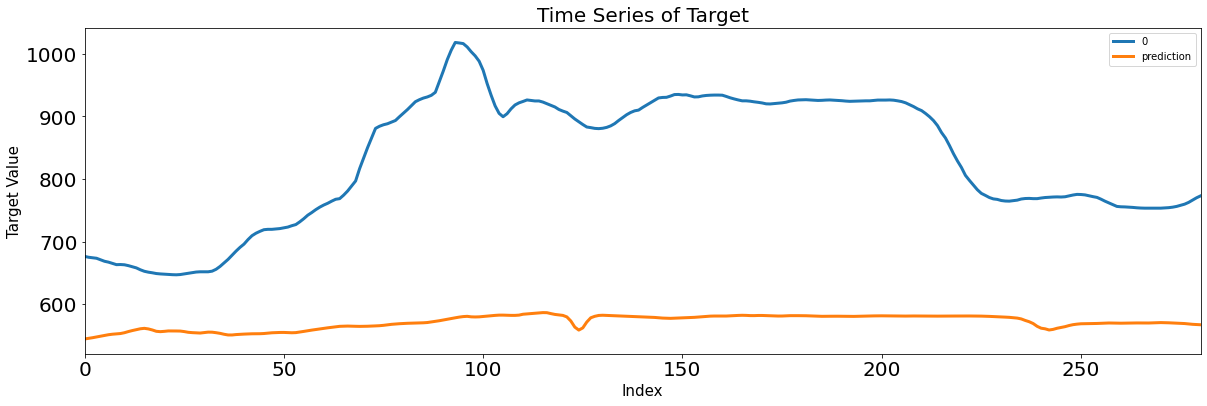

In [107]:
#################################################################################
#
# ----- Feature 1, LSTM 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = round(len(raw_all.index) * (1- PCT), 0)

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# # Feature Engineering
# ## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
# test = raw_all.loc[raw_all.index >= criteria,:]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

# ## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)


####################### iterations #######################
# Score = dict()
# seqsize_list = [i for i in range(1, 21, 1)]
# for i in tqdm(seqsize_list):
#     sequence = i
        
## X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test), callbacks = [early_stopping])

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)
if simul_test == 1:
    Score[str(sequence)] = Score_LSTM

In [108]:
if simul_test == 1:
    # Performance plot by sequence length
    seq_test = pd.DataFrame()
    for key, val in Score.items():
        seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

    seq_test = seq_test.T
    seq_test.index = seqsize_list
    seq_test['MSE'].plot(figsize=(12,4))
    plt.show()

X_train: (476, 5, 1) Y_train: (476, 1)
X_test: (281, 5, 1) Y_test: (281, 1)
Epoch 1/1000
30/30 [==============================] - 7s 61ms/step - loss: 0.0699 - val_loss: 0.7053
Epoch 2/1000
30/30 [==============================] - 1s 36ms/step - loss: 0.0258 - val_loss: 0.3918
Epoch 3/1000
30/30 [==============================] - 1s 36ms/step - loss: 0.0223 - val_loss: 0.2322
Epoch 4/1000
30/30 [==============================] - 1s 37ms/step - loss: 0.0217 - val_loss: 0.2435
Epoch 5/1000
30/30 [==============================] - 1s 37ms/step - loss: 0.0221 - val_loss: 0.4844
Epoch 6/1000
30/30 [==============================] - 1s 37ms/step - loss: 0.0220 - val_loss: 0.4147
Epoch 7/1000
30/30 [==============================] - 1s 37ms/step - loss: 0.0230 - val_loss: 0.2117
Epoch 8/1000
30/30 [==============================] - 1s 38ms/step - loss: 0.0219 - val_loss: 0.3043
Epoch 9/1000
30/30 [==============================] - 1s 36ms/step - loss: 0.0217 - val_loss: 0.5124
Epoch 10/1000
3

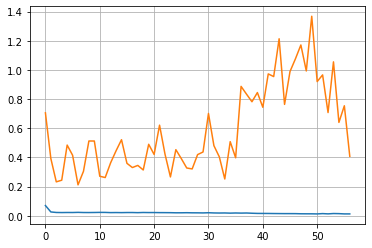

9/9 [==============================] - 0s 13ms/step - loss: 8.6858e-15


,MAE,MSE,MAPE
Train,15.04,359.92,3.11
Test,98.62,"13,256.85",11.73


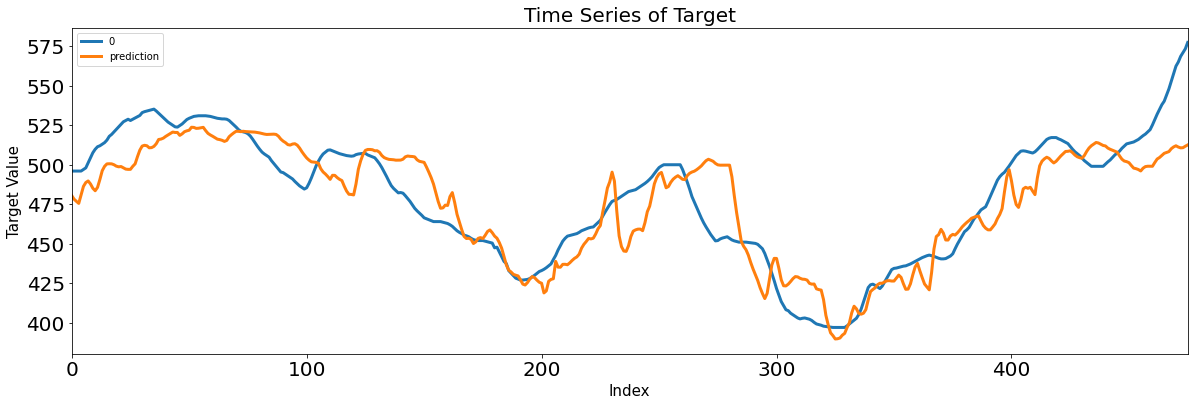

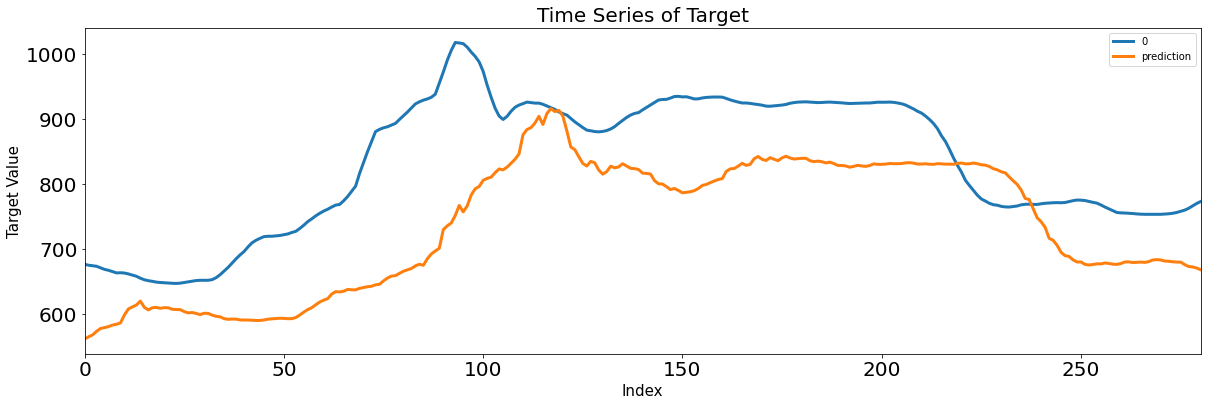

In [109]:
#################################################################################
#
# ----- Feature 1, GRU 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = round(len(raw_all.index) * (1- PCT), 0)

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# Feature Engineering
## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
# test = raw_all.loc[raw_all.index >= criteria,:]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)

# sequence = 5
# epoch = 50
# batch_size = 16

# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 50, mode = 'min')



####################### iterations #######################
# Score = dict()
# batchsize_list = [i for i in range(5, 11, 5)]
# for i in tqdm(batchsize_list):
#     # sequence = i
#     batch_size = i

## X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test), callbacks = [early_stopping])

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)
if simul_test == 1:
    Score[str(batch_size)] = Score_GRU

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

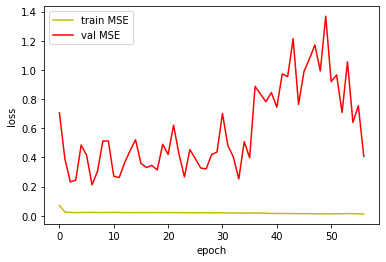

In [110]:
# 5. 모델 학습과정 표시하기 - epoch 시뮬일 때만 실행
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

loss_ax.plot(model_fit.history['loss'], 'y', label = 'train MSE')
loss_ax.plot(model_fit.history['val_loss'], 'r', label = 'val MSE')
# acc_ax.plot(model_fit.history['MAE'], 'b', label = 'train MAE')
# acc_ax.plot(model_fit.history['val_MAE'], 'g', label = 'val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'auto')
# acc_ax.legend(loc = 'lower left')

plt.show()


In [111]:
if simul_test == 1:
    # Performance plot by sequence length - 시퀀스/배치 변경에 따른 MSE 기록 -> 최적화 찾기 
    seq_test = pd.DataFrame()
    for key, val in Score.items():
        seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

    seq_test = seq_test.T
    seq_test.index = seqsize_list
    seq_test['MSE'].plot(figsize=(12,4))
    plt.show()

In [112]:
# print(scaler.inverse_transform(X_test[0]))
# print(X_test[0].shape)
# print(Y_test[0])
# print(Y_test_pred[0])